In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/footwear/Footwear/Shoe/Shoe (4).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (616).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (234).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (331).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (802).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (251).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (595).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (289).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (991).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (419).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (674).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (486).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (296).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (818).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (378).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (539).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (467).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (10).jpg
/kaggle/input/footwear/Footwear/Shoe/Shoe (894).jpg
/kaggle/input/f

In [2]:
!pip install protobuf==3.20.3

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display

# run GPU
print("TensorFlow Version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2025-12-12 08:36:01.425879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765528561.447219     304 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765528561.453559     304 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# data reading 

In [4]:
dataset_path = '/kaggle/input/footwear/Footwear'

In [5]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3         
BATCH_SIZE = 128

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        label_mode=None,       
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        shuffle=True
    )

Found 3000 files.


I0000 00:00:1765528569.008304     304 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



... Displaying Sample Images (Before Normalization)


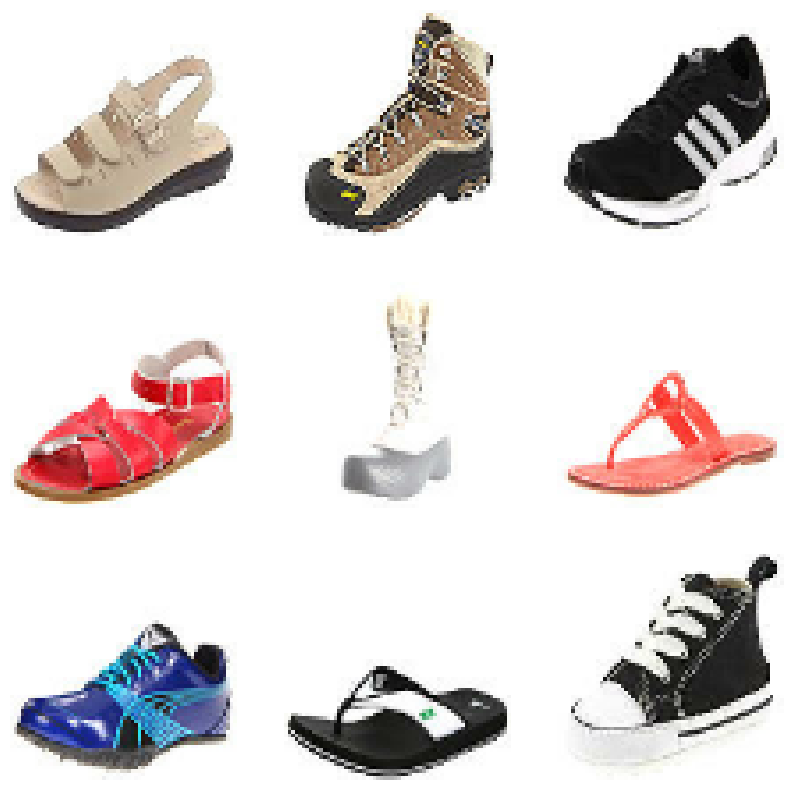

In [7]:
    # visualization before normalization
    print("\n... Displaying Sample Images (Before Normalization)")
    plt.figure(figsize=(10, 10))
    for images in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            # الصور جاية float فلازم نحولها لـ int عشان تتعرض صح
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()


In [8]:
# 4. normalization
def normalize(image):
    image = tf.cast(image, tf.float32)
    return (image - 127.5) / 127.5

train_dataset = train_ds.map(normalize)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # (Seed)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    # maximize x2
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # maximize x2
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # final result (64x64)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # CNN layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
noise_dim = 100
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
EPOCHS = 50 
seed = tf.random.normal([16, noise_dim])

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    if (epoch + 1) % 5 == 0:
        display.clear_output(wait=True)
        predictions = generator(seed, training=False)
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            # return the original colors
            plt.imshow((predictions[i] * 0.5 + 0.5))
            plt.axis('off')
        plt.show()
        print(f'Epoch {epoch + 1} finished in {time.time()-start:.2f} sec')

  display.clear_output(wait=True)

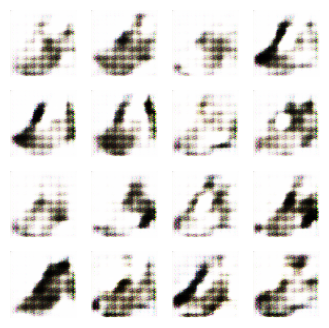

Epoch 50 finished in 1.61 sec


In [20]:
predictions = generator(seed, training=False)
fig = plt.figure(figsize=(4, 4))
for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i] * 0.5 + 0.5))
      plt.axis('off')
plt.show()

train(train_dataset, EPOCHS)

In [21]:
def calculate_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))
    return (real_accuracy + fake_accuracy) / 2

In [22]:
for image_batch in train_dataset.take(1):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    generated_images = generator(noise, training=False)

    real_output = discriminator(image_batch, training=False)
    fake_output = discriminator(generated_images, training=False)

    d_loss = discriminator_loss(real_output, fake_output)
    g_loss = generator_loss(fake_output)
    
    disc_acc = calculate_accuracy(real_output, fake_output)

In [23]:
print(f"Generator Loss:{g_loss.numpy():.4f}")
print(f"Discriminator Loss: {d_loss.numpy():.4f}")
print(f"Discriminator Accuracy: {disc_acc.numpy() * 100:.2f}%")

Generator Loss:1.1069
Discriminator Loss: 0.9377
Discriminator Accuracy: 83.98%
